<a href="https://colab.research.google.com/github/zorocrit/2025-Graduation-Project/blob/main/megumin_nerf_2503220207.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycolmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 87.5 MB/s eta 0:00:00


In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive

In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
FOLDERNAME = 'G_Drive/nerf_data'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/Othercomputers/{}'.format(FOLDERNAME))

# Change dariectory to current folder
%cd /content/drive/Othercomputers/$FOLDERNAME

/content/drive/Othercomputers/G_Drive/nerf_data


In [8]:
from pathlib import Path
import pycolmap
sparse_dir = Path("sparse/0")  # COLMAP에서 생성된 데이터가 저장된 폴더
image_dir = Path("images")  # 실제 이미지가 저장된 폴더
reconstruction = pycolmap.Reconstruction("sparse/0")
print(reconstruction)

Reconstruction(num_cameras=272, num_images=272, num_reg_images=272, num_points3D=2502)


In [10]:
# 카메라 정보 가져오기
cameras = reconstruction.cameras
camera = list(cameras.values())[0]  # 첫 번째 카메라 정보 사용

# COLMAP images.bin 파일 경로
images_bin_path = "sparse/0"

# images.bin 파일 로드
reconstruction = pycolmap.Reconstruction()
reconstruction.read(images_bin_path)

# 첫 번째 이미지 객체 확인 (구조 분석)
image_ids = list(reconstruction.images.keys())
first_image = reconstruction.images[image_ids[0]]

# Rotation3d 객체 확인
rotation_data = first_image.cam_from_world.rotation

# Rotation3d 객체가 어떤 속성을 가지고 있는지 확인
print(dir(rotation_data))

IndexError: list index out of range

In [ ]:
# Focal Length 및 해상도 가져오기
focal = camera.focal_length
H, W = camera.height, camera.width
print(f"Camera Info: Focal Length = {focal}, Image Size = ({W}, {H})")

# 2️⃣ 이미지 및 포즈 데이터 가져오기 (images.bin)
image_data = reconstruction.images
sorted_images = sorted(image_data.items(), key=lambda x: x[1].name)
# 3️⃣ 이미지 배열 및 카메라 포즈 배열 만들기
image_list = []
pose_list = []
print(f"Total images in COLMAP reconstruction: {len(image_data)}")

# 2️⃣ 이미지 및 포즈 데이터 가져오기 (images.bin)
image_data = reconstruction.images
sorted_images = sorted(image_data.items(), key=lambda x: x[1].name)
print(f"Total images in COLMAP reconstruction: {len(image_data)}")

Camera Info: Focal Length = 435.2073492809049, Image Size = (360, 360)
Total images in COLMAP reconstruction: 193
Total images in COLMAP reconstruction: 193


In [ ]:
def qvec_to_rotmat(qvec):
    """
    Convert a quaternion (w, x, y, z) to a 3x3 rotation matrix.

    Parameters:
    qvec (array-like): Quaternion in the form (w, x, y, z).

    Returns:
    np.ndarray: 3x3 rotation matrix.
    """
    w, x, y, z = qvec
    R = np.array([
        [1 - 2 * (y * y + z * z), 2 * (x * y - z * w), 2 * (x * z + y * w)],
        [2 * (x * y + z * w), 1 - 2 * (x * x + z * z), 2 * (y * z - x * w)],
        [2 * (x * z - y * w), 2 * (y * z + x * w), 1 - 2 * (x * x + y * y)]
    ])
    return R

In [ ]:
def focal_mm_to_pixels(f_mm, image_width, sensor_width_mm):
    """밀리미터 단위의 초점 거리를 픽셀 단위로 변환"""
    f_pixels = f_mm * (image_width / sensor_width_mm)
    return f_pixels

# 예제 값
f_mm = 23.8  # 초점 거리 (mm)
image_width = 1440  # 이미지 가로 해상도 (pixels)
sensor_width_mm = 13.02  # 센서 가로 크기 (mm)

focal = focal_mm_to_pixels(f_mm, image_width, sensor_width_mm)
print(f"픽셀 단위 초점 거리: {focal} pixels")

픽셀 단위 초점 거리: 2632.2580645161293 pixels


In [ ]:
# 3️⃣ 이미지 배열 및 카메라 포즈 배열 만들기
image_list = []
pose_list = []

### 이미지 경로 확인 코드

In [ ]:
# for image in image_dir.glob("*.png"):
#     img_path = image_dir / image.name
#     print(f"Trying to load: {img_path}")  # 🔥 디버깅용 출력

#     img = cv2.imread(str(img_path))
#     if img is None:
#         print(f"❌ Failed to load image: {img_path}")  # ❌ 이미지 로드 실패 메시지
#         continue  # 다음 이미지로 넘어감

#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환
#     image_list.append(img)

In [ ]:
# img_path = str((image_dir / image.name).resolve())  # 절대 경로 변환
# img = cv2.imread(img_path)

In [ ]:
# from PIL import Image

# try:
#     with Image.open(img_path) as img:
#         img.verify()  # 손상된 이미지 확인
#     print(f"✅ Image is valid: {img_path}")
# except Exception as e:
#     print(f"❌ Corrupted image detected: {img_path} - {e}")

In [ ]:
for img_id, image in sorted_images:
    img_path = image_dir / image.name
    img = cv2.imread(str(img_path))  # 이미지 로드
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환
    image_list.append(img)

    # COLMAP의 카메라 포즈 변환 (Rigid3d → 4x4 변환 행렬)
    pose = np.eye(4)  # 4x4 단위 행렬 생성

    # 🔹 Quaternion (w, x, y, z) → 3x3 회전 행렬 변환
    qvec = np.array(image.cam_from_world.rotation.quat)
    pose[:3, :3] = qvec_to_rotmat(qvec)  # Quaternion을 3x3 회전 행렬로 변환

    # 🔹 Translation 벡터 변환 (COLMAP은 camera-to-world 변환이므로 부호 반전)
    pose[:3, 3] = -np.array(image.cam_from_world.translation)

    # 🔹 COLMAP 좌표계를 OpenGL 좌표계로 변환 (NeRF 호환)
    pose = np.diag([1, -1, -1, 1]) @ pose  # YZ 축 반전 (COLMAP → OpenGL)

    #print(f"Image {img_id} pose matrix:\n{pose}\n")  # 변환된 행렬 출력
    pose_list.append(pose)


In [ ]:
# 이미지 리스트 → NumPy 배열 변환 (dtype 명확히 지정)
images = np.stack(image_list, axis=0)  # np.array() 대신 np.stack() 사용
poses = np.stack(pose_list, axis=0)    # 포즈도 같은 방식으로 변환
print("Images Shape: " + str(images.shape) + ", Poses Shape: " + str(poses.shape) + ",  Focal Value: " + str(focal))

Images Shape: (193, 360, 360, 3), Poses Shape: (193, 4, 4),  Focal Value: 2632.2580645161293


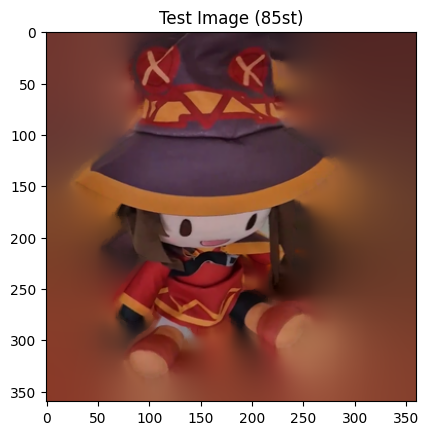

In [ ]:
# 4️⃣ 특정 테스트 이미지 및 포즈 선택

img_test = 85
testimg, testpose = images[img_test], poses[img_test]

# 🔹 NeRF 학습용으로 사용할 이미지 개수 설정 (100개로 제한하지 않음)
train_images = images  # 193개 이미지 전부 사용
train_poses = poses  # 193개 포즈 전부 사용

# 🔹 테스트 이미지 출력
plt.imshow(testimg)
plt.title("Test Image (" + str(img_test) + "st)")
plt.show()

In [ ]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed,))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.keras.layers.Lambda(lambda x: tf.concat(x, axis=-1))([outputs, inputs])
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    rays_o = tf.cast(rays_o, tf.float32)  # 🔹 float32 변환
    rays_d = tf.cast(rays_d, tf.float32)  # 🔹 float32 변환

    z_vals = tf.linspace(tf.cast(near, tf.float32), tf.cast(far, tf.float32), N_samples)  # 🔹 float32 변환
    z_vals = tf.cast(z_vals, tf.float32)  # 🔹 float32 변환

    # # Compute 3D query points
    # z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

In [ ]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')